### Supervised regression task for artificial neural network

In [1]:
import json
import matplotlib
import warnings
import numpy as np
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.metrics import roc_auc_score

warnings.simplefilter('ignore')
root = r"/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML/styles/bmh_matplotlibrc.json"
s = json.load(open(root))
matplotlib.rcParams.update(s)
%matplotlib inline

In [2]:
# hours of sleep, hours study, score on test
X = np.array(([3, 5], [5, 1], [10, 2]), dtype=float)
y = np.array(([75], [82], [93]), dtype=float)
# scale the data, here we just dividing by the max
X = X / X.max()
y = y / y.max() 

In [3]:
#Training Data:
trainX = np.array(([3, 5], [5, 1], [10, 2], [6, 1.5]), dtype=float)
trainY = np.array(([75], [82], [93], [70]), dtype=float)

#Test Data
testX = np.array(([4, 5.5], [5.5, 1], [9, 2.5], [6, 2]), dtype = float)
testY = np.array(([70], [89], [85], [75]), dtype=float)

#Normalized
trainX = trainX / np.amax(trainX, axis = 0)
trainY = trainY / 100.

testX = testX / np.amax(testX, axis = 0)
testY = testY / 100.

In [4]:
class _Neural_Network(object):
    def __init__(self, Lambda = 0):
        #Define hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Regularization parameter
        self.Lambda = Lambda
        
        self.W1 = np.random.rand(self.inputLayerSize, self.hiddenLayerSize)
        self.W2 = np.random.rand(self.hiddenLayerSize, self.outputLayerSize)
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def forward(self, X):
        #propagate inputs through network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yhat = self.sigmoid(self.z3)
        return yhat 
    
    def sigmoidPrime(self, z):
        #Derivative of Sigmoid Function
        return np.exp(-z) / ((1 + np.exp(-z))**2)
    
    def costFunction(self, X, y):
        """
        linear regression cost function
        """
        self.yhat = self.forward(X)
        J = 0.5*sum((y - self.yhat)**2)/X.shape[0] + (self.Lambda/2)*((np.sum(self.W1**2)) + (np.sum(self.W2**2)))
        return J
    
    def costFunctionPrime(self, X, y):
        #Compute drivative with respect to W1 and W2
        
        yhat = self.forward(X)
        
        delta3 = np.multiply(-(y - yhat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1
        
        return dJdW1, dJdW2
    
    def getParams(self):
        #Set W1, W2, W3 Rolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1, W2, W3 unsing single parameter vector:
        W1_start = 0
        W1_end = self.hiddenLayerSize*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize, self.hiddenLayerSize))
        
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2  = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel() ,dJdW2.ravel()))

In [5]:
class trainer(object):
    def __init__(self, N):
        #Make local reference to Neural Network:
        self.N = N
        
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(trainX, trainY)
        grad = self.N.computeGradients(X, y)
        return cost, grad
      
    def callBackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.trainX, self.trainY))
        self.J_test.append(self.N.costFunction(self.testX, self.testY))
        
    def train(self, trainX, trainY, testX, testY):
        #Make internal variable for callback function
        self.trainX = trainX
        self.trainY = trainY
        
        self.testX = testX
        self.testY = testY
        
        #Make empty list to store costs
        self.J = []
        self.J_test = []
        
        #initial parameters
        params0 = self.N.getParams()
        
        options = {'maxiter': 1000, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac = True, method='BFGS',\
                        args = (trainX, trainY), options = options, callback = self.callBackF )
        
        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [6]:
def computeNumericalGradient(N, X, y):
    paramsInitial = N.getParams()
    numgrad = np.zeros(paramsInitial.shape)
    pertub = np.zeros(paramsInitial.shape)
    e = 1e-4
    
    for p in np.arange(len(paramsInitial)):
        #Set pertubabtion vector
        pertub[p] = e
        N.setParams(paramsInitial + pertub)
        loss2 = N.costFunction(X, y)
        
        N.setParams(paramsInitial - pertub)
        loss1 = N.costFunction(X, y)
        
        #Compute Numerical Gradient:
        numgrad[p] = (loss2 - loss1) / (2*e)
        
        #Return the value we changed back to zeros
        pertub[p] = 0
        
    #Return Params to original value:
    N.setParams(paramsInitial)
    
    return numgrad

In [7]:
#to futher reduce overfitting we could increase Lambda
NN = _Neural_Network(Lambda = 0.0001)

In [8]:
num_grad = computeNumericalGradient(NN, X, y)
grad = NN.computeGradients(X, y)

#Let's check how similar our two gradient are must be <= 1e-8 
(np.linalg.norm(grad - num_grad) / np.linalg.norm(grad + num_grad)) 

1.0498162289188615e-10

In [9]:
T = trainer(NN)
T.train(trainX, trainY, testX, testY)

Optimization terminated successfully.
         Current function value: 0.002618
         Iterations: 149
         Function evaluations: 152
         Gradient evaluations: 152


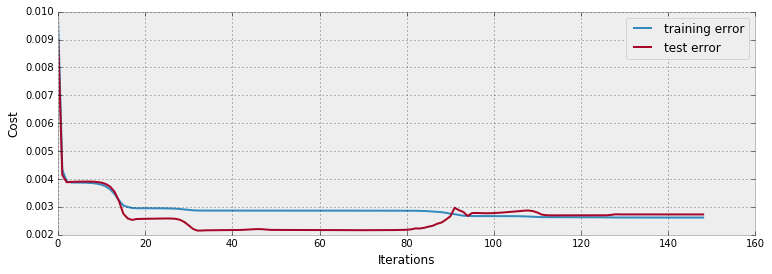

In [10]:
figsize(12.5, 4)
plt.plot(T.J, label = 'training error')
plt.plot(T.J_test, label = 'test error')
plt.grid(1)
plt.ylabel('Cost')
plt.xlabel('Iterations');
plt.legend(loc = "upper right");

In [11]:
NN.forward(X)

array([[ 0.74218245],
       [ 0.78035427],
       [ 0.85634795]])

In [12]:
y

array([[ 0.80645161],
       [ 0.88172043],
       [ 1.        ]])